In [39]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2" # select GPUs to use
import torch
import pytorch_lightning as pl
import torchphysics as tp

In [40]:
width, height = 2.0, 1.0
t_0, t_end = 0, 20
Re = 50

U = tp.spaces.R2('u')
X = tp.spaces.R2('x')
T = tp.spaces.R1('t')

In [41]:
box = tp.domains.Parallelogram(X, [0.0, 0.0], [width, 0.0], [0.0, height])
hole = tp.domains.Circle(X, [width/3.0, 0.0], height/3.0)
omega = box - hole
t_int = tp.domains.Interval(T, t_0, t_end)

In [42]:
model = tp.models.FCN(X*T, U, hidden=(50,50,50,50,20))

def constrain_fn(u, x, t):
    u_con = t * u * x[:, :1]
    u_con[:, :1] += (1-torch.exp(-t))
    u_con *= (height - x[:, 1:]) * x[:, 1:]
    return u_con

In [43]:
def pde_residual(u, x, t):
    u = constrain_fn(u, x, t)
    u_t = tp.utils.jac(u, t).squeeze(-1)
    u_1 = tp.utils.laplacian(u[:, :1], x)
    u_2 = tp.utils.laplacian(u[:, 1:], x)
    u_lap = torch.column_stack((u_1, u_2))
    conv = tp.utils.convective(u, x, u) # convection term
    return u_t + conv - 1/Re * u_lap

pde_sampler = tp.samplers.RandomUniformSampler(box*t_int, n_points=25000)
pde_condition = tp.conditions.PINNCondition(model, pde_sampler, pde_residual)

In [44]:
def bc_residual(u, x, t):
    u = constrain_fn(u, x, t)
    return u

def filter(x):
    return x[:, 1:] >= 0.0
bc_sampler = tp.samplers.RandomUniformSampler(hole.boundary*t_int, n_points=10000, filter_fn=filter)
bc_condition = tp.conditions.PINNCondition(model, bc_sampler, bc_residual)

In [45]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.001)
solver = tp.solver.Solver([pde_condition, bc_condition],
                          optimizer_setting=optim)


trainer = pl.Trainer(gpus=1, # or None for CPU
                     max_steps=10000,
                     logger=False,
                     benchmark=True,
                     checkpoint_callback=False)
trainer.fit(solver)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 8.9 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
8.9 K     Trainable params
0         Non-trainable params
8.9 K     Total params
0.036     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [46]:
t_sampler = tp.samplers.GridSampler(t_int, n_points=128) \
             + tp.samplers.GridSampler(t_int.boundary, n_points=2)
inner_sampler = tp.samplers.RandomUniformSampler(omega, n_points=2000) * t_sampler
bc_sampler = tp.samplers.RandomUniformSampler(hole.boundary*t_int, n_points=25000, filter_fn=filter)
bc_sampler = bc_sampler.make_static()
inner_sampler = inner_sampler.make_static()
bc_condition.sampler = bc_sampler
pde_condition.sampler = inner_sampler

optim = tp.OptimizerSetting(optimizer_class=torch.optim.LBFGS, lr=0.5, 
                            optimizer_args={'max_iter': 2, 'history_size': 100})
solver = tp.solver.Solver([pde_condition, bc_condition],
                          optimizer_setting=optim)


trainer = pl.Trainer(gpus=1, # or None for CPU
                    max_steps=2000,
                    logger=False,
                    benchmark=True,
                    checkpoint_callback=False)
trainer.fit(solver)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 8.9 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
8.9 K     Trainable params
0         Non-trainable params
8.9 K     Total params
0.036     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/home/tomfre/Desktop/torchphysics/src/torchphysics/problem/domains/domainoperations/sampler_helper.py:49: UserWarning: Will sample random points in the created domain operation, with
                     a for loop over all input parameters, in total: 130
                     This may slow down the training.
  warnings.warn(f"""Will sample random points in the created domain operation, with


Validating: 0it [00:00, ?it/s]

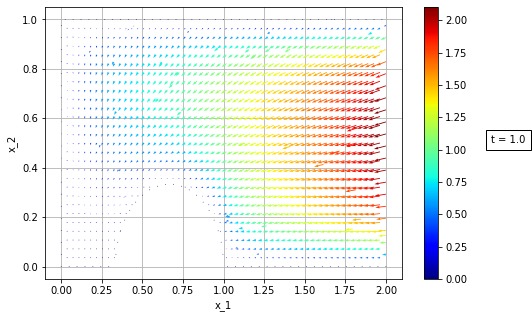

In [50]:
plot_sampler = tp.samplers.PlotSampler(omega, n_points=1500, data_for_other_variables={'t':1.0,})
fig = tp.utils.plot(model, constrain_fn, plot_sampler)
fig.set_size_inches(8, 5)

In [48]:
ani_sampler = tp.samplers.AnimationSampler(omega, t_int, frame_number=100, n_points=800)
#fig, ani = tp.utils.animate(model, constrain_fn, ani_sampler)
#ani.save("test.gif")